# Персонализация предложений интернет-магазина средствами МО

Руководство интернет-магазина "В один клик" поставило перед нашим отделом задачу - разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность. 

Руководитель отдела цифровых технологий уже сформулировал решение:
- Промаркировать уровень финансовой активности постоянных покупателей: «снизилась», если клиент стал покупать меньше товаров, или «прежний уровень».
- Собрать данные по клиентам по следующим группам:
 - Признаки, которые описывают коммуникацию сотрудников компании с клиентом.
 - Признаки, которые описывают продуктовое поведение покупателя. Например, какие товары покупает и как часто.
 - Признаки, которые описывают покупательское поведение клиента. Например, сколько тратил в магазине.
 - Признаки, которые описывают поведение покупателя на сайте. Например, как много страниц просматривает и сколько времени проводит на сайте.
 
В конечном итоге нам нужно построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца, и, используя данные модели и данные о прибыльности клиентов, выделить сегменты покупателей и разработать для них персонализированные предложения.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Предобработка данных</a></span></li><li><span><a href="#Исследовательский-анализ" data-toc-modified-id="Исследовательский-анализ-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Исследовательский анализ</a></span></li></ul></div>

**Описание данных**

1. `market_file.csv` - данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.
 - id — номер покупателя в корпоративной базе данных.
 - Покупательская активность — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
 - Тип сервиса — уровень сервиса, например «премиум» и «стандарт».
 - Разрешить сообщать — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это  даёт покупатель.
 - Маркет_актив_6_мес — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
 - Маркет_актив_тек_мес — количество маркетинговых коммуникаций в текущем месяце.
 - Длительность — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
 - Акционные_покупки — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
 - Популярная_категория — самая популярная категория товаров у покупателя за последние 6 месяцев.
 - Средний_просмотр_категорий_за_визит — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
 - Неоплаченные_продукты_штук_квартал — общее число неоплаченных товаров в корзине за последние 3 месяца.
 - Ошибка_сервиса — число сбоев, которые коснулись покупателя во время посещения сайта.
 - Страниц_за_визит — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.


2. `market_money.csv` - данные о выручке, которую получает магазин с покупателя, сколько покупатель всего потратил за период взаимодействия с сайтом.
 - id — номер покупателя в корпоративной базе данных.
 - Период — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.
 - Выручка — сумма выручки за период.


3. `market_time.csv` - данные о времени (в минутах), которое покупатель провёл на сайте в течение периода.
 - id — номер покупателя в корпоративной базе данных.
 - Период — название периода, во время которого зафиксировано общее время.
 - минут — значение времени, проведённого на сайте, в минутах.


4. `money.csv` - данные о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.
 - id — номер покупателя в корпоративной базе данных.
 - Прибыль — значение прибыли.

In [81]:
import pandas as pd # Импорт необходимых библиотек
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
import numpy as np

try: # Библиотеки phik нету в окружении практикума по умолчанию. На всякий пожарный использую конструкцию try-except при импорте
    import phik
except:
    phik_loc = False
else:
    phik_loc = True
phik_loc

True

In [82]:
#pd.options.mode.chained_assignment = None # На случай, если пандас будет выпендриваться. Удалить, если не используется
sns.set_style('dark') # Устанавливаем стиль для графиков

## Загрузка данных

In [83]:
def dataset_info(ds, info=True): # Универсальная функция презентации данных
    print('Количество дубликатов:', ds.duplicated().sum())
    print('Длина датасета:', len(ds))
    display(ds.head())
    if info: 
        ds.info()
        display(ds.describe())

Для начала загрузим данные и ознакомимся с ними.

In [84]:
try: # Проект запускается либо в окружении практикума, либо локально. 
    ds_main = pd.read_csv('/datasets/market_file.csv')
except:
    ds_main = pd.read_csv('datasets/market_file.csv')
dataset_info(ds_main)

Количество дубликатов: 0
Длина датасета: 1300


,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

,id,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,215997.500000,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,375.421985,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,215348.000000,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,215672.750000,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,215997.500000,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,216322.250000,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


Ни одного явного дубликата. Названия столбцов вполне информативны, разве-что привести их к нижнему регистру. Тип сервиса "стандартт" вызывает подозрения, возможно это ошибка заполнения или дубликат значения. Отложим это на этап предобработки. Всем данным уже присвоен соответствующий тип. В целом можно сказать, что данные в хорошем состоянии.

In [85]:
try: 
    ds_money = pd.read_csv('/datasets/market_money.csv')
except:
    ds_money = pd.read_csv('datasets/market_money.csv')
dataset_info(ds_money)

Количество дубликатов: 0
Длина датасета: 3900


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


,id,Выручка
count,3900.000000,3900.000000
mean,215997.500000,5025.696051
std,375.325686,1777.704104
min,215348.000000,0.000000
25%,215672.750000,4590.150000
50%,215997.500000,4957.500000
75%,216322.250000,5363.000000
max,216647.000000,106862.200000


Никаких дубликатов, значения соответствуют ожидаемым. В датасете значительно больше записей, 3900 против 1300 из основного датасета. Это связано с тем, что здесь представлены несколько периодов для каждого айди.

In [86]:
try: 
    ds_time = pd.read_csv('/datasets/market_time.csv')
except:
    ds_time = pd.read_csv('datasets/market_time.csv')
dataset_info(ds_time)

Количество дубликатов: 0
Длина датасета: 2600


,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


,id,минут
count,2600.000000,2600.000000
mean,215997.500000,13.336154
std,375.349754,4.080198
min,215348.000000,4.000000
25%,215672.750000,10.000000
50%,215997.500000,13.000000
75%,216322.250000,16.000000
max,216647.000000,23.000000


Похожая ситуация, записей больше из-за нескольких периодов. Видна грамматическая ошибка в значении "предыдцщий_месяц". Запомнили.

In [87]:
try: 
    ds_mean_money = pd.read_csv('/datasets/money.csv', sep=';', decimal=",")
except:
    ds_mean_money = pd.read_csv('datasets/money.csv', sep=';', decimal=",")
dataset_info(ds_mean_money)

Количество дубликатов: 0
Длина датасета: 1300


,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


,id,Прибыль
count,1300.000000,1300.000000
mean,215997.500000,3.996631
std,375.421985,1.013722
min,215348.000000,0.860000
25%,215672.750000,3.300000
50%,215997.500000,4.045000
75%,216322.250000,4.670000
max,216647.000000,7.430000


Среднее значение среднемесячной прибыли за последние 3 месяца - 4. Кажется, это не рубли, а как минимум тысячи рублей. Этот момент стоит уточнить у тех, кто составлял данные. Пока будем отталкиваться от предположения, что прибыль указывается в тысячах рублей. В остальном с данными всё в порядке, количество записей совпадает с основным датасетом. На этом можно заканчивать загрузку данных и переходить к следующему этапу.

## Предобработка данных

Для начала - приведём все названия столбцов к нижнему регистру для удобства.

In [88]:
ds_main.columns = ds_main.columns.str.lower()
ds_money.columns = ds_money.columns.str.lower()
ds_time.columns = ds_time.columns.str.lower()
ds_mean_money.columns = ds_mean_money.columns.str.lower()
print(ds_main.columns, ds_money.columns, ds_time.columns, ds_mean_money.columns)

Index(['id', 'покупательская активность', 'тип сервиса', 'разрешить сообщать',
       'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'популярная_категория',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит'],
      dtype='object') Index(['id', 'период', 'выручка'], dtype='object') Index(['id', 'период', 'минут'], dtype='object') Index(['id', 'прибыль'], dtype='object')


Теперь пройдёмся по подозрительным значениям, которые нам удалось заметить. Например, тип сервиса "стандартт". На всякий случай посмотрим на уникальные значения всех категориальных столбцов.

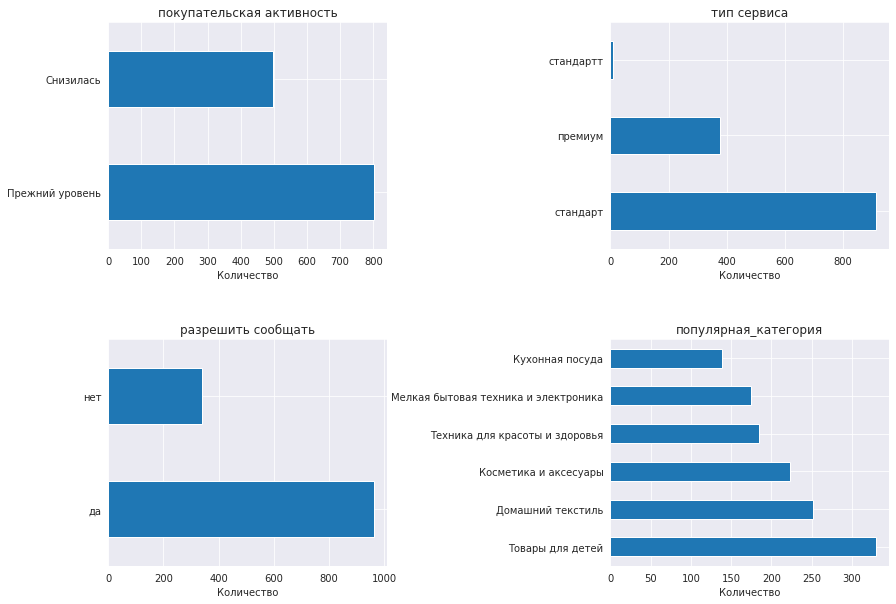

In [89]:
fig, axes = plt.subplots(nrows=2, ncols=2)
j=0
for i in ds_main.select_dtypes(exclude='number').columns:
    ds_main[i].value_counts().plot(kind='barh', figsize=(14, 10), ax=axes[j//2, j%2], grid=True)
    axes[j//2, j%2].set_title(i)
    axes[j//2, j%2].set_xlabel('Количество')
    j+=1
plt.subplots_adjust(wspace=0.8, hspace=0.4)
plt.show()

Да, значение "стандартт" - неявный дубликат значения "стандарт". В остальных столбцах неявных дубликатов нет.

In [90]:
ds_main.loc[ds_main['тип сервиса'] == 'стандартт', 'тип сервиса'] = 'стандарт'
ds_main['тип сервиса'].unique()

array(['премиум', 'стандарт'], dtype=object)

Раз-уж заговорили про категориальные параметры - посмотрим на столбец с периодом из `ds_time`.

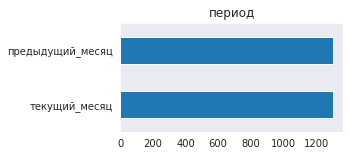

In [97]:
ds_time['период'].value_counts().plot(kind='barh', figsize=(4, 2), title='период');

А это уже простая ошибка наименования. Исправим её

In [92]:
ds_time.loc[ds_time['период'] == 'предыдцщий_месяц', 'период'] = 'предыдущий_месяц'
ds_time['период'].unique()

array(['текущий_месяц', 'предыдущий_месяц'], dtype=object)

И на этом предобработку можно заканчивать. Мы привели названия столбцов к нижнему регистру и избавились от двух неявных дубликатов в данных.

## Исследовательский анализ